## Task 0 (Know your Data) - Exploratory Data Analysis

## 0.1. Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(filename):
    """Load CSV file with any number of consecutive features, starting in column 0, where last column is the class"""
    df = pd.read_csv(filename)
    nc = df.shape[1] # number of columns
    matrix = df.values # Convert dataframe to darray
    table_X = matrix [:, 0:nc-1] # get features 
    table_y = matrix [:, nc-1] # get class (last columns)           
    features = df.columns.values[0:nc-1] #get features names
    target = df.columns.values[nc-1] #get target name
    return table_X, table_y, features, target

In [4]:
examples, target, fnames, tname = load_data('PetFinder_dataset.csv')

Loading colour, breed and state labels:

In [8]:
color_labels = pd.read_csv('color_labels.csv').set_index('ColorID')
breed_labels = pd.read_csv('breed_labels.csv').set_index('BreedID')
state_labels = pd.read_csv('state_labels.csv').set_index('StateID')

## 0.2. Understanding Data

### Basic Questions

#### How big is the dataset?
The dataset contains 14993 entries with 24 features each.

#### Is this the entire dataset?
The original dataset from PetFinder.my contains over 150,000 animal profiles.

#### Is this data representative enough?
The dataset represents ~10% of the original data. EDA is required to best assess whether it can be considered a representative sample of the original population.

#### Are there likely to be gross outliers or extraordinary sources of noise?
EDA can shed light on this topic, by representing data distribution and irregularities that could point to errors in data.

#### Are there any fields that are unique identifiers? These are the fields you might use for joining between datasets, etc.
All animal profiles are uniquely identified by a PetID. Each PetID also has a non-unique RescuerID, and a non-unique State.

#### Are the supposedly unique identifiers actually unique? What does it mean if they aren't?
PetID.

#### When data entries are blank, where does that come from?
The only blank entries in this dataset correspond to animal profiles without an assigned name.

#### How common are blank entries?
There are ~1200 blank entries, which constitute a significant portion of the data. Given this number, and due to the fact that blank entries have meaning attributed to them, it would perhaps be best to keep this data in the dataset for analysis.

### Exploratory Data Analysis

In order to better understand our dataset and to make decisions about feature selection, feature extraction and general cleaning of the data, we started by plotting distribution of the original features and the target.

#### Target: *AdoptionSpeed*

The target feature displayed a clear discrepancy in distribution, showing a significantly lower number of examples for AdoptionSpeed = 0. This imbalance should be addressed, as models tend to neglect minority classes if they don't have a large enough representation in the overall dataset, therefore compromising the classification.

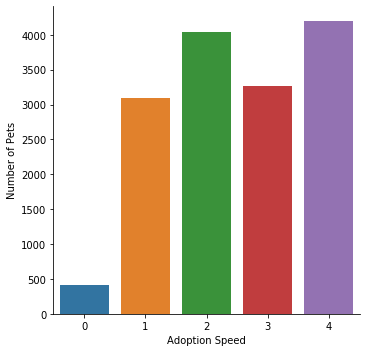

In [2]:
data_raw = pd.read_csv('PetFinder_dataset.csv')

ax = sns.catplot(x="AdoptionSpeed",data=data_raw, kind='count')
(ax.set_axis_labels("Adoption Speed", "Number of Pets"))

#### Type

Because we are going to later create type-specific predictive models, it would be relevant to see the number of cases we have in our dataset for each animal (cat or dog).

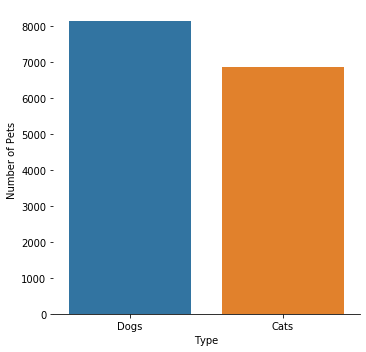

In [6]:
bx = sns.catplot(x="Type",data=data_raw, kind='count')
(bx.set_axis_labels("Type", "Number of Pets")
    .set_xticklabels(["Dogs", "Cats"])
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

Looking at our data, we conclude the number of examples is fairly proportional, as well as their distribution relative to the target class, making the resulting models' performance more comparable.

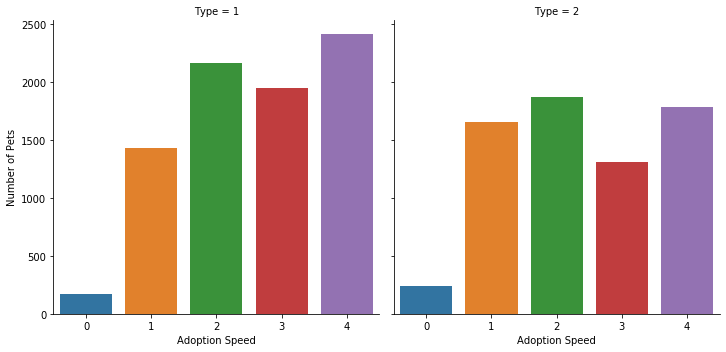

In [7]:
cx = sns.catplot(x="AdoptionSpeed",col="Type",data=data_raw, kind='count')
(cx.set_axis_labels("Adoption Speed", "Number of Pets"))

#### Age

*Distribution, periodic peaks (1, 2, 3, ... years) --> in 1.1m explain how we intend to divide ages by bins*

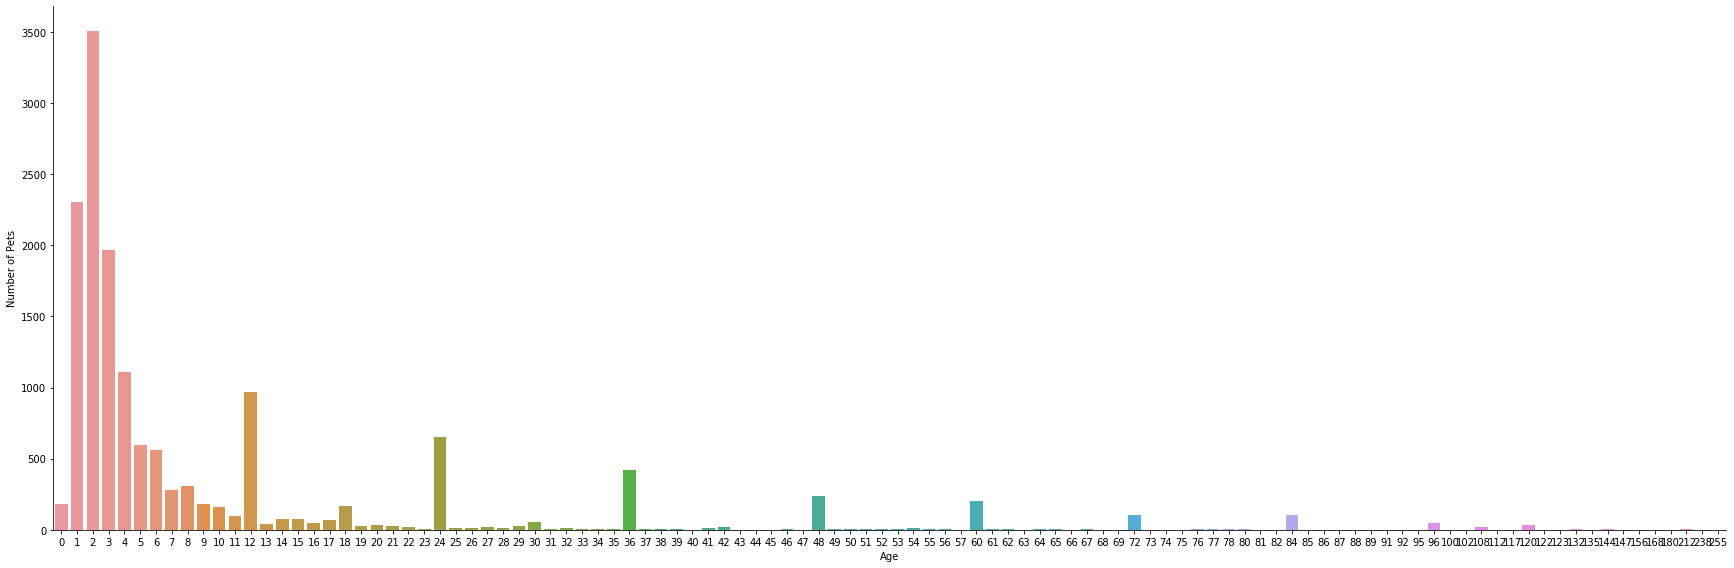

In [13]:
dx = sns.catplot(x="Age", data=data_raw,kind='count',height=8, aspect=3)
(dx.set_axis_labels("Age", "Number of Pets"))

in 1.1m explain how we intend to divide ages by bins*

#### Breed1 and Breed2

According to the breeds feature labels, dogs breeds go from 1 to 240, plus 307, and cats breeds go from 241 to 306. 

Looking at our data, and according to the breeds feature labels, we found some cats with the dogs breeds assigned to them (15, 21, 25, 70, 114, 205, 218, 307).
Therefore, and given the distribution of pets by breeds we decided as first approach to group pets by pure-race/mixed-race. Whenever a pet is assigned with only one breed, breeds 1 and 2 are equal or one of the breeds is not 307 (mixed breed), that pet w, whenever they are assigned with only one breed or, and by mixed-race, whe

1.1 --> explain how we intend to divide by pure vs. mixed breed*

#### Color1, Color2 and Color3

Each pet has at least one main color (color1) that according to the colors features label can go from black(1) to white(7). Pets can also have one or two additional colors (color2 and color3) with the same categorical values as the main color.

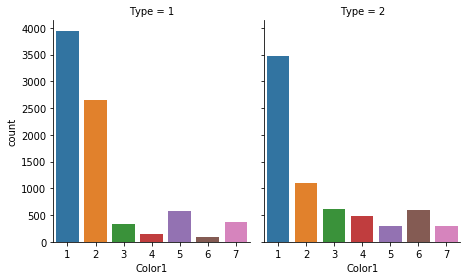

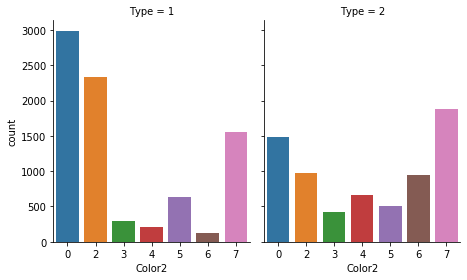

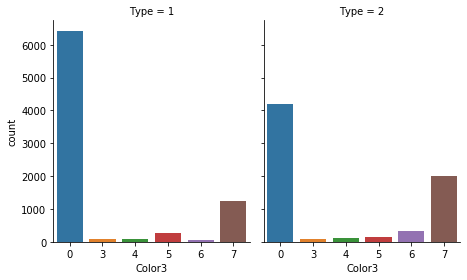

In [15]:
zx1 = sns.catplot(x="Color1",col="Type",data=data_raw, kind='count',height=4, aspect=0.8)
zx2 = sns.catplot(x="Color2",col="Type",data=data_raw, kind='count',height=4, aspect=0.8)
zx3 = sns.catplot(x="Color3",col="Type",data=data_raw, kind='count',height=4, aspect=0.8)

Given the number of values for each color feature we decided to test two different approaches to the Color1, Color2 and Color3 features: 
* Group pets according to the number of colors one has. Pets with only one color will be assigned a "SingleColor" feature and so on;
* Group colours according to their brightness/darkness.

#### Quantity

XXXXXXXXX

#### Fee

XXXXXXXXX

#### State

XXXXXXXXX

#### RescuerID

In order to extract some meaning from the 'RescuerID', we decided, as a first approach, to find out whether is frequent for rescuers to save and advertise multiple pets.

There are 5595 unique rescuers in the dataset
There are 3783 rescuers with only 1 webpage entry in the dataset
There are 1812 rescuers with more than 1 webpage entry in the dataset


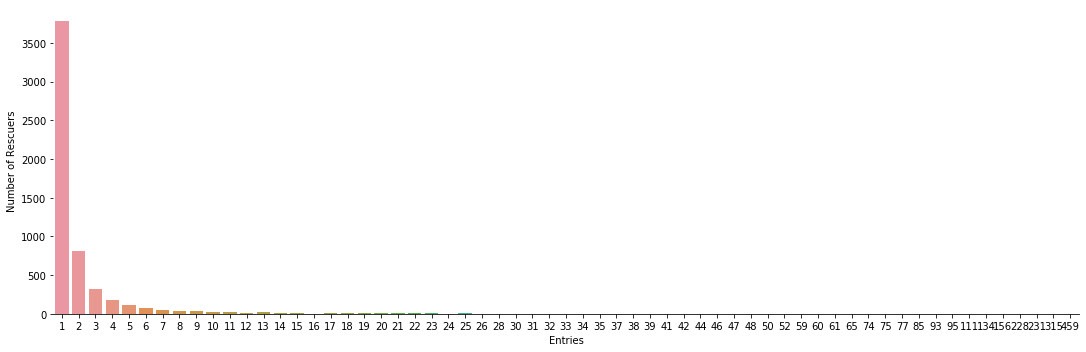

In [19]:
x = list(data_raw['RescuerID'].unique())
y = list(data_raw['RescuerID'])
z = []
t = {}
for i in x:
    z.append( y.count(i))

t['Rescuer'] = x
t['entries'] = z

e = pd.DataFrame(t)
print('There are {} unique rescuers in the dataset'.format(len(x)))
print('There are {} rescuers with only 1 webpage entry in the dataset'.format(z.count(1)))
print('There are {} rescuers with more than 1 webpage entry in the dataset'.format(len(x)-(z.count(1))))
ax11 = sns.catplot(x='entries', data=e, kind='count', height=5, aspect=3)
(ax11.set_axis_labels("Entries", "Number of Rescuers")
    .set_titles("{col_name} {col_var}")
    .despine(left=True))  

According to the dataset, the number of rescuers with a single entry in the MyPet webpage is greater than the number of rescuers who save and advertise more than 1 pet. This information could be useful on later anaylsis to discover wheter the number of webpage profile entries associated with a rescuer has any interference in pet's apoption or adoption speed.

#### VideoAmt

xxxxxxxxxxxx.

#### Description

In order to extract some meaning from the 'Description', we decided, as a first approach, to partition this continuous feature into discrete values.

Since empty descriptions (size=0) probably have a direct influence in the adoption choice, it should be a category of its own. For that reason, we exclude empty descriptions from the discretization procces.

We consider that the discretization of the 'description sizes' based on the quantiles strategy is appropriate, since it is plausible to say that the ad writers define what a 'medium' size description is. In that sense, a 'medium' sized description would have the average word count. In analogy, the smallest and largest descriptions would correspond to the first and third quantiles.

Based on these results, we present a new feature 'DescriptionSize' whose possible values include:
* 'Empty' for descriptions containing 0 words
* 'Small' for descriptions containing between 1 and 28 words
* 'Medium' for descriptions containing between 29 and 65 words
* 'Large' for descriptions containing between 66 and 1257 words

#### PetID

Since PetID is not informative of the pet profile (it acts solely as a unique identifier of the page), it would be excluded from the analysis, although it will be used as an index for the dataFrame. It can be later useful when evaluating model performance, as the respective record values can reveal if certain features were appropriately categorised.

The average descripton size: 62.953645034349364
According to this discretization, the bin edges should be:
[array([   0.,   28.,   65., 1257.])]


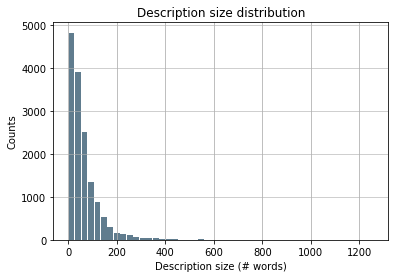

In [21]:
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
import statistics 

l=[]
df = pd.read_csv('PetFinder_dataset.csv')

# List descriptions' lengths (i.e. number of char)
for i in df['Description']:
    if type(i)!=str: # Some empty descriptions are type:float
        l.append(0)
    else:
        l.append(len(i.split()))

mean = statistics.mean(l)
print("The average descripton size:" , mean)

# Histogram
a1 = np.asarray(l)
nr_bins = 1 + 3.322*math.log(len(l),2) # Number of bins according to Sturges rule
a1 = pd.Series(a1)
a1.plot.hist(grid=True, bins = round(nr_bins), rwidth=0.9, color='#607c8e')
plt.title('Description size distribution')
plt.xlabel('Description size (# words)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

# Discretization by quantile strategy:
a2 = np.asarray(l).reshape(-1,1) # Reshape data since we are working with just one feature
est = preprocessing.KBinsDiscretizer(n_bins=[3],encode='ordinal', strategy='quantile').fit(a2)
decp = est.transform(a2)

print("According to this discretization, the bin edges should be:")
print(est.bin_edges_) # how the data is distributed in the four bins

#### Photo Amt

xxxxxxxxxxxx.

#### Predictions and hypotheses
Named vs. nameless profiles

Rescuers with higher adoption rates

##### Photos/videos vs. no photos/videos
* **PhotoAmt: No photo vs. photos**
* Analysing the distribution of AdoptionSpeed with regards to PhotoAmt, there is a clear distinction between animals with no photos (which have a higher proportion of AdoptionSpeed = 4) and animals with 1 or more photos (which have a more uniform distribution).

More photos/videos vs. less photos/videos

One animal vs. multiple animals

Cats vs. dogs

Multiple pets for one rescuer vs. one pet for one rescuer (profiles with more than one pet will suggest other pets by the same rescuer; possibly influences users to explore pets of the same rescuer more often)

Free adoption vs. paid adoption

#### Disproportionate data
If data is not represetantive of a specific feature, consider removing it; might skew the analysis of that feature (e.g.: if only a few animals exist in State X and all are adopted, model might conclude all animals in State X are always adopted)

AdoptionSpeed = 0 is less frequent that AdoptionSpeed > 0, but it can reflect the reality of adoption for animais in the website

In this task you should **understand better the features**, their distribution of values, potential errors, etc and plan/describe what data preprocessing steps should be performed next. Very important also is the distribution of values in the target (class distribution). 

Here you can find a notebook with some examples of what you can do in **Exploratory Data Analysis**: https://www.kaggle.com/artgor/exploration-of-data-step-by-step/notebook. You can also use Orange widgets for this.

...

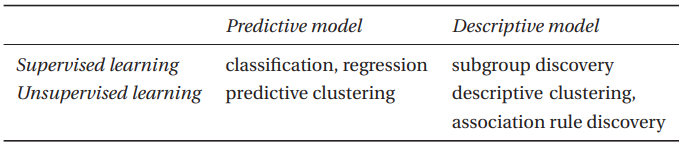

**Task 1** will consist in a supervised learning predictive task.

**Task 2** will consist in an unsupervised learning descriptive task.

## Task 1 (Supervised Learning) - Predicting Adoption and Adoption Speed

In this task you should target 3 classification tasks:
1. **Predicting  Adoption (binary classification task)**: create a new target from AdoptionSpeed that is 1 if AdoptionSpeed <> 4 and 0 otherwise.
2. **Predicting AdoptionSpeed (multiclass classification)**: in this task you should you the original target AdoptionSpeed, whose values are in the set {0, 1, 2, 3 , 4} (5 classes). This is a very difficult problem. You might also want to consider 3 classes (for instance {0-1, 2-3, 4}, or other sets that make sense). 
3. **Train specialized models for cats and dogs**: train with cat/dog instances and check whether the classification performance changes when Predicting Adoption and Predicting AdoptionSpeed.

**You should:**

* Choose **one classifier in each category**: Tree models, Rule models, Linear models, Distance-based models, and Probabilistic models.
* Use cross-validation to evaluate the results. 
* Present and discuss the results for different evaluation measures, present confusion matrices. Remember that not only overall results are important. Check what happens when learning to predict each class.
* Describe the parameters used for each classifier and how their choice impacted or not the results.
* Choose the best classifier and fundament you choice. (Confusion matrices w/ accuracy for various targets)
* **Discuss critically your choices and the results!**

## 1.1. Preprocessing Data for Classification

Data to exclude from datasets:
* Description (?)
* PetID (?) --> converted to index
* RescuerID (?)

Data to convert:
* Description (?) --> # of character
* RescuerID (?) --> count
* Breed1 and Breed2 --> Breed (0 if pure, 1 if mixed)

Data to separate:
* Gender = 3, in gender-dependent analysis



## 1.2. Learning Classifiers

...

## 1.3. Classification - Results and Discussion 

...

## Task 2 (Unsupervised Learning) - Charactering Adopted Pets and Adoption Speed

In this task you should **use unsupervised learning algorithms and try to characterize pets that were actually adopted and their adoption speed**. You can use:
* **Association rule mining** to find **associations between the features and the target Adoption/AdoptionSpeed**.
* **Clustering algorithms to find similar groups of pets**. Is it possible to find groups of pets with the same/similar adoption speed.
* **Be creative and define your own unsupervised analysis!** What would it be interesting to find out ?

## 2.1. Preprocessing Data for Association Rule Mining

...

## 2.2. Finding Associations

...

## 2.3 Association Rules - Results and Discussion 

...

## 2.4. Preprocessing Data for Clustering

...

## 2.5. Finding Groups

...

## 2.6. Clustering - Results and Discussion 

...

## 3. Final Comments and Conclusions

...